### Example using an MLP with one hidden layer to solve the XOR problem
CITS5508 Machine Learning

If we have two classes of 2D points that form clusters that look like a $2 \times 2$ checker board, then the data points are known to be not linearly separable. This is the well-known Exclusive-Or Classificaton problem. Perceptron, like other linear classification algorithms, cannot solve this problem. However,if we add a second Perceptron and stack it on top of the first Perceptron, then the multilayer perceptron (or MLP) can solve the XOR problem, as demonstrated in the code in this Notebook. The implementation does require a suitable activation function in the hidden layer, as shown in the code below.

Du Huynh<br>
June 2020

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.model_selection import train_test_split

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs - you may want to remove this line
# if you want to see how the results differ on different runs of the whole Notebook.
np.random.seed(2020)
tf.random.set_seed(2020)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

print('sklearn.version =', sklearn.__version__)
print('tf.version      =', tf.__version__)

sklearn.version = 0.22.1
tf.version      = 2.0.0


In [2]:
def synthesizePoints(N, minx, miny, maxx, maxy):
    N = np.cast[np.int32](N/4)
    points = np.r_[np.random.normal(loc=(minx,miny), size=(N,2)),
               np.random.normal(loc=(maxx,maxy), size=(N,2)),
               np.random.normal(loc=(minx,maxy), size=(N,2)),
               np.random.normal(loc=(maxx,miny), size=(N,2))]
    labels = np.r_[np.zeros(N+N), np.ones(N+N)]
    return points, labels

def plotPoints(X, ys, class_names, title_str):
    '''
    This function plots the 2D data points stored in X in two subplots using
    the binary labels (0 or 1) stored in ys that are generated from two
    models.
    @param X should be of shape (N,2) storing the 2D points for plotting.
    @param ys should be of shape (1,N) or (2,N) storing the corresponding
        class labels from the two algorithms.
    @param class_names should be a list containing two class symbols (used as
        markers in the subplots).
    @param title_str should be a list containing two character strings for the
        titles of the two subplots.
    '''
    Nsubplots = ys.shape[0]
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    for ax,splot in zip(axes, range(2)):
        if Nsubplots > splot:
            for k in range(2):
                index = (ys[splot,:] == k)
                ax.plot(X[index,0], X[index,1], class_names[k])
            ax.set_xlabel("x", fontsize=14)
            ax.set_ylabel('y', fontsize=14)    
            ax.set_title(title_str[splot])
            ax.axis('equal')
    if Nsubplots == 1:
        axes[1].axis('off')
    plt.show()

### Synthesize the data points

We synthesize 1000 2D points for each class to simulate the XOR problem. Total number of data points is therefore 2000.

In [3]:
points, labels = synthesizePoints(2000, 0, 0, 9, 9)
class_names = ['x', 'o']

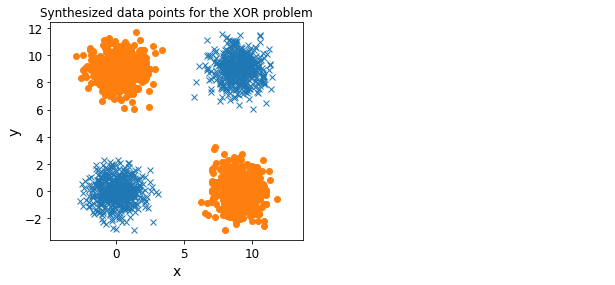

In [4]:
plotPoints(points, labels[np.newaxis], class_names, ['Synthesized data points for the XOR problem'])

### Construct the training set  and test set

In [5]:
X_train, X_test, y_train, y_test = train_test_split(points, labels, test_size=0.2)

print('Training set size =', y_train.shape[0])
print('Test set size =', y_test.shape[0])

Training set size = 1600
Test set size = 400


### Comparing the performance of two MLPs on the XOR classification problem

A few activation functions have been experimented for the hidden layer (i.e., the first `Dense` layer).

* If no activation function is used, the loss value plateaus at around 0.6935 and the accuracy fluctuates between 0.3 and 0.55. Having no activation function is known to be not working well, as, without any activation function, the weight matrices of the two layers will collapse to a single weight matrix, making the MLP behave as a Perceptron.
* If the **ReLu** activation function is used, the highest accuracy reached is around 0.75
* The best result is obtained when the **SELU** activation function is used, with a training accuracy above 0.99 at the end of training.

For the output layer, we have only one neuron to output a probability value for our binary classification problem. The only suitable activation function is **sigmoid**.

A large `XORtest` function is used to wrap both models as local variables inside the function. If the models were global variables, then the previous training weights of the layers seem to be stored in cache and were carried forward even though a new model was created for each individual test. This is particularly the case when we give a specific name and we reuse the name in another model. By making the models as local variables, they only exist inside the function. Only two models are compared in the `XORtest` function. These two models either use the **ReLU** or **SELU** activation function in the hidden layer. Other activation functions, such as **ELU** can also be tested, of course. Note that because of the randomness involved in initializing the network weights, the model that uses **ReLU** can occasionally outperform the model that uses **SELU**. However, on average, it seems that **SELU** performs better more frequently.

In the `XORtest` function, both models are trained for 100 epochs. So the `verbose` option is set to 0 to turn off the printing of training loss and training accuracy at the end of each epoch. To see how the training progresses, we can set `verbose=1`. An alternative is to write a callback function and specify how often (e.g., every 20th epoch) we want the loss and accuracy to be printed and pass this callback function to the `fit` function.

In [6]:
def XORtest(X_train, y_train, X_test, y_test, class_names, max_epoch = 100, print_wts = False):
    
    test_set_size = len(y_test)
    model_name = ['MLP_with_SELU', 'MLP_with_ReLU']
    activ_func = ['selu', 'relu']
    model = {}
    y_pred = np.empty([2, test_set_size], dtype=np.uint8)
    accuracy = np.empty([2], dtype=np.float32)

    for i in range(2):
        # create the MLP
        model[i] = keras.models.Sequential(name=model_name[i])
        model[i].add(keras.layers.Dense(2, activation=activ_func[i], input_shape=[2]))
        model[i].add(keras.layers.Dense(1, activation="sigmoid"))

        # train the MLP        
        print('Training', model_name[i], ':')
        model[i].compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=['accuracy'])
        model[i].fit(X_train, y_train, epochs=max_epoch, verbose=0)
        
        # test the MLP on the test set
        print('*** Testing', model_name[i], ':')
        # Note that model.predict outputs the class probabilities. To get the class labels, we
        # need to round each probability value to the nearest integer (0.0 or 1.0) and then
        # cast it to integer type (0 or 1).
        y_pred_proba = model[i].predict(X_test).ravel()
        y_pred[i] = np.round(y_pred_proba).astype(np.uint8)
        accuracy[i] = np.sum(y_pred[i] == y_test) / len(y_test)
        print('Classification accuracy on the test set =', accuracy[i])
        if print_wts:
            for l in range(2):
                wts, biases = model[i].layers[l].get_weights()
                print('Layer', str(l))
                print('weights ='), print(wts)
                print('biases ='), print(biases)          
        print()

    # now plot the prediction results of the two models side-by-side
    plotPoints(X_test, y_pred, class_names, ['Classification results from ' + model_name[i] for i in range(2)])
    
    return accuracy
    

Training MLP_with_SELU :
*** Testing MLP_with_SELU :
Classification accuracy on the test set = 1.0

Training MLP_with_ReLU :
*** Testing MLP_with_ReLU :
Classification accuracy on the test set = 0.735



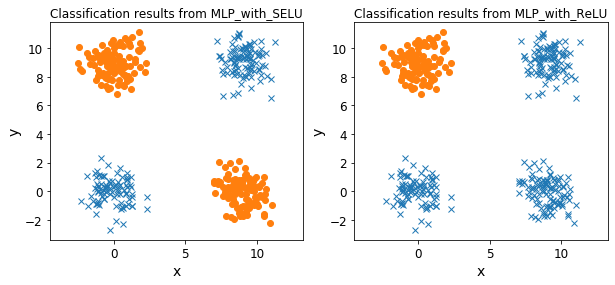

In [7]:
accuracy = XORtest(X_train, y_train, X_test, y_test, class_names)

### Modifying the data set ...

We can try modifying the dataset so that all the data point coordinates are positive to see if the model that uses the `ReLU` activation function can improve its performance. The reason that we suspect about this issue is because `ReLU` only outputs positive values to the next layer; however, the results are inconclusive. If we run the cell below several times, we will see that the `ReLU` can sometimes win over `SELU`. Both models can sometimes fail very badly also. So it seems that we need to look into both the feature scaling step and weight initialization to make sure that the models give more consistent performance.

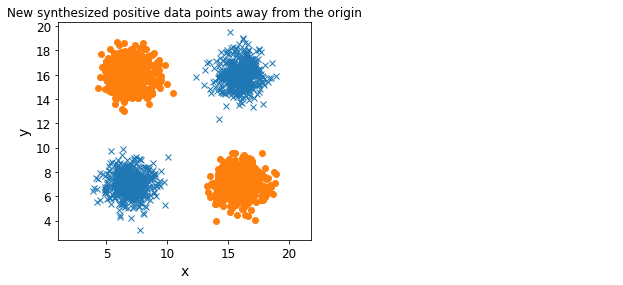

Training MLP_with_SELU :
*** Testing MLP_with_SELU :
Classification accuracy on the test set = 0.9775

Training MLP_with_ReLU :
*** Testing MLP_with_ReLU :
Classification accuracy on the test set = 0.755



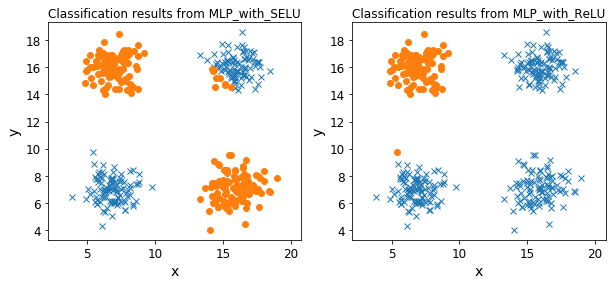

In [8]:
# modifying the dataset and run XORtest again
points, labels = synthesizePoints(2000, 7, 7, 16, 16)
plotPoints(points, labels[np.newaxis], class_names, ['New synthesized positive data points away from the origin'])
X_train, X_test, y_train, y_test = train_test_split(points, labels, test_size=0.2)
accuracy = XORtest(X_train, y_train, X_test, y_test, class_names)

### Normalizing the data points...

We use the `StandardSCaler` from `sklearn` and add some control to prevent the data points are scaled differently for both axes (in this synthesized dataset, it actually doesn't matter because of we set $xmax-xmin = ymax-ymin$ when we call the `synthesizePoints` function). After this normalization, we should then try different ways of initializing the network weights, test the models at least a few times to see whether the results vary significantly from run to run.

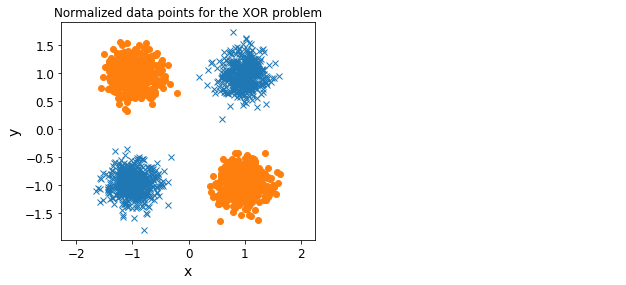

In [9]:
from sklearn.preprocessing import StandardScaler

# work out the scale ourselves by combining the horizontal and vertical coordinates
combined_std = np.std(X_train.ravel())

# Note the important ordering of operations below: use fit_transform
# to translate the origin then perform the scaling. The result will be
# wrong if we scale then translate.
scaler = StandardScaler(with_std=False)  # specify no scaling operation to be performed
X_train = scaler.fit_transform(X_train)  # this will translate the origin to the centre of mass of features
X_train = X_train / combined_std         # scale the features ourselves

X_test = scaler.transform(X_test)
X_test = X_test / combined_std

plotPoints(np.r_[X_train, X_test], np.r_[y_train,y_test][np.newaxis], class_names, 
            ['Normalized data points for the XOR problem'])

Training MLP_with_SELU :
*** Testing MLP_with_SELU :
Classification accuracy on the test set = 1.0
Layer 0
weights =
[[-3.809144  -1.2453718]
 [ 3.8113124  1.2369682]]
biases =
[-1.7519782  0.8241014]
Layer 1
weights =
[[ 2.8569055]
 [-4.1235456]]
biases =
[2.6683147]

Training MLP_with_ReLU :
*** Testing MLP_with_ReLU :
Classification accuracy on the test set = 0.7375
Layer 0
weights =
[[1.5348818  0.9401444 ]
 [1.4532481  0.89953876]]
biases =
[-1.0816308  -0.67713505]
Layer 1
weights =
[[-3.285271 ]
 [-3.7136233]]
biases =
[0.70692056]



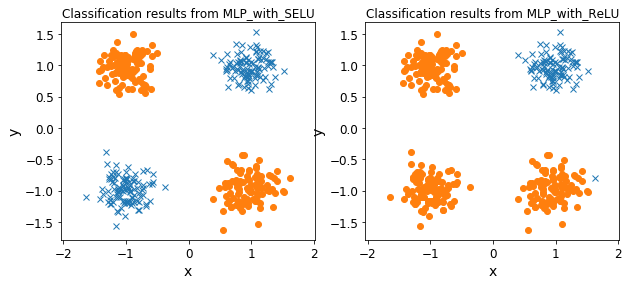

In [10]:
# now train the two models and test them on the test set.
accuracy = XORtest(X_train, y_train, X_test, y_test, class_names, print_wts=True)

### Comparison between SELU and ReLU

One should puzzle why the performance of `MLP_with_ReLU` is less consistent compared to `MLP_with_SELU`. The SELU activation function is a smooth function (differentiable everywhere) when the default value 1 is used for the parameter $\lambda$, whereas ReLU is not differentiable at the origin. Is this the main reason that ReLU did not do well on this dataset? Apart from the differentiable issue at the origin, there is another difference between ReLU and SELU: ReLU outputs only positive values to the next layer; however, SELU outputs a negative value if the input is negative. Maybe this limit on the range of values hinders the performance of ReLU. Occasionally by luck, ReLU could reach above 90% classification accuracy on the test set, but its performance is not consistent on different runs.

Note that we didn't do any batch normalization in both MLPs above. We should also investigate different ways to initialize the connection weights and other activation functions as well, e.g., `ELU` and `tanh`.


### Exercise:

* Create some new MLPs similar to the `MLP_with_ReLU` and  `MLP_with_SELU` in the `XORtest` function, except that a **Batch Normalization** layer is put after the first hidden layer, test the performance of these models on the test set of the normalized data above.

* Try also other activation functions and weight initialization strategies.

* Note that you will need to test the models at least a few times to see whether the models' performances are consistent for different runs. e.g., run XORtest inside a `for` loop and inspect the returned array of accuracies of the two models.